In [17]:
import pandas as pd
import numpy as np

In [5]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 
'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 
'Total phenols', 'Flavanoids',
'Nonflavanoid phenols', 
'Proanthocyanins', 
'Color intensity', 'Hue', 
'OD280/OD315 of diluted wines', 
'Proline']


In [7]:
###Want to use the train_test_split function from sklearn's cross_validation submodule.

from sklearn.cross_validation import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
train_test_split(X,y, test_size=0.3, random_state = 0)


### Scaling features

In [9]:
### Decision Trees and Random Forests dont need to be scaled
### Can use normalization or standardization
### Normalization is rescaling features to a range of [0,1]
### Min max scaling can be implemented as folloe

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [10]:
from sklearn.preprocessing import StandardScaler
stdsc =StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### Selecting Meaningful Features

##### Sparse solutions with L1 regularization

In [13]:
#Uses the sum of absolute values of weights as the penalty
# Yields sparse feature vectors
# Can be considered feature selection
# Section 3.4 has a good explaination of l1 and l2 regularization

from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty = 'l1')

lr = LogisticRegression(penalty = 'l1', C = 0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))




Training accuracy: 0.983870967742
Test accuracy: 0.981481481481


In [14]:
lr.intercept_

array([-0.38382407, -0.15806998, -0.70035222])

In [15]:
lr.coef_

array([[ 0.27992392,  0.        ,  0.        , -0.02782429,  0.        ,
         0.        ,  0.71008958,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23684699],
       [-0.64398404, -0.06881014, -0.05720691,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92678611,
         0.06023304,  0.        , -0.3710962 ],
       [ 0.        ,  0.06136075,  0.        ,  0.        ,  0.        ,
         0.        , -0.6368993 ,  0.        ,  0.        ,  0.49855928,
        -0.35824378, -0.57020475,  0.        ]])

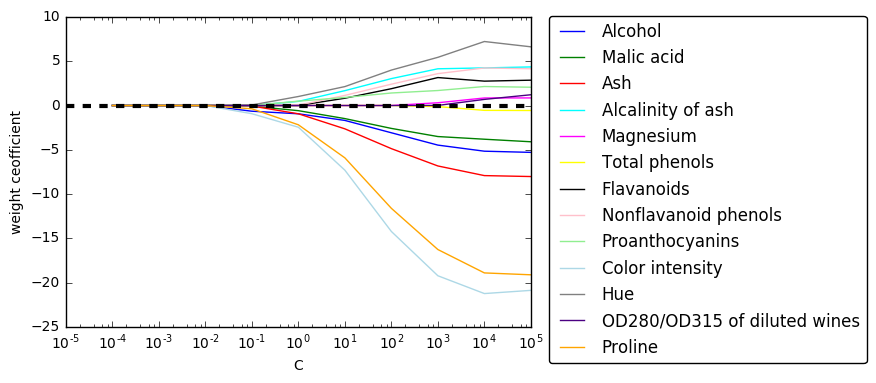

In [20]:
### Plotting regularization paths

import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan',
         'magenta', 'yellow', 'black',
         'pink', 'lightgreen', 'lightblue',
         'gray', 'indigo', 'orange']

weights, params = [], []

for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty = 'l1', 
                           C=10**c,
                           random_state = 0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
            label=df_wine.columns[column+1],
             color=color)

plt.axhline(0,color = 'black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight ceofficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc = 'upper center', 
         bbox_to_anchor=(1.38, 1.03),
         ncol =1, fancybox=True)
plt.show()

#### Sequential Feature Selection Algorithms

In [21]:
## Implementing Sequential Backward Selection from Scratch 

from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features,
                scoring=accuracy_score,
                test_size=0.25, random_state = 1):
                self.scoring = scoring
                self.estimator = clone(estimator)
                self.k_features = k_features
                self.test_size = test_size
                self.random_state = random_state
                
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size = self.test_size, 
                        random_state = self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                            X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
        
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, 
                                    X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
        
            self.scores_.append(scores[best])
        
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    
        
                

In [24]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors = 2)
sbs = SBS(knn, k_features = 1)
sbs.fit(X_train_std, y_train)

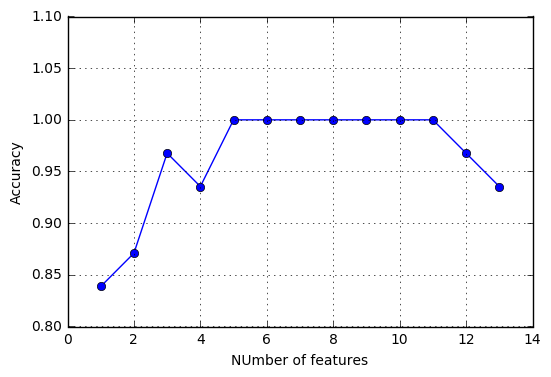

In [26]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylim([0.8, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('NUmber of features')
plt.grid()
plt.show()

In [28]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [29]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test Accuracy: ', knn.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test Accuracy:  0.944444444444


In [31]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:,k5], y_test))

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963


In [32]:
#Feature Importance with Random Forests

from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators = 10000,
                               random_state = 0,
                               n_jobs = 1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f],
                           importances[indices[f]]))

 1) Alcohol                        0.182483
 2) Malic acid                     0.158610
 3) Ash                            0.150948
 4) Alcalinity of ash              0.131987
 5) Magnesium                      0.106589
 6) Total phenols                  0.078243
 7) Flavanoids                     0.060718
 8) Nonflavanoid phenols           0.032033
 9) Proanthocyanins                0.025400
10) Color intensity                0.022351
11) Hue                            0.022078
12) OD280/OD315 of diluted wines   0.014645
13) Proline                        0.013916


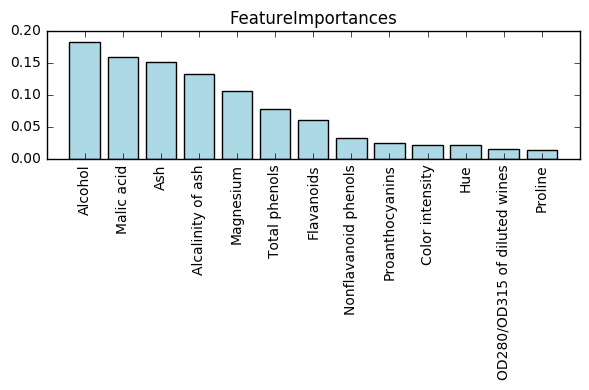

In [36]:
plt.title('FeatureImportances')
plt.bar(range(X_train.shape[1]),
       importances[indices],
       color='lightblue',
       align='center')
plt.xticks(range(X_train.shape[1]),
           feat_labels, rotation = 90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()